In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns; sns.set()
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from pandas.util import hash_pandas_object

#### Import data

In [2]:
data = pd.read_csv('../data/en.openfoodfacts.org.products.csv', sep = '\t')

/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Explore different colums available

In [3]:
header = data.columns
odf = pd.DataFrame()
for index in header:
    odf[index] =( [index , sum(data[index].notnull())/1023451*100  , data[index].value_counts().head(4).index.tolist() ])
odf=odf.T
odf =odf.drop(columns=0)
odf=odf.rename(columns={1: "%", 2: "exemple top-4"})

In [4]:
odfcut=odf[odf["%"]>=3]

In [5]:
odfcut.to_csv('odfcut.csv')


# CATEGORIES FOOD

Categories each product according to the PNNS

https://www.cerin.org/rapports/groupes-groupes-daliments/

In [6]:
# 8 category from PNNS norm
pnns_category = {'Dairies','Composite','Fish Meat Eggs','Beverages','Fat Sauces','Fruits Vegetables','Starchy','Snacks'}

In [7]:
# dictionnary to normalize category names into PNNS category
# put the PNNS category in a master column of category "Category_Food"
pnns1_category = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}
data['Category_Food'] = data['pnns_groups_1'].replace(pnns1_category)

More category from 'main_category_en' source

In [8]:
# dictionnary to normalize category names into PNNS category
maincategoryen_category = {'unknown' : 'Unknown',
'Plant-based foods and beverages' : 'Berevages',
'Snacks' : 'Snacks',
'Beverages' : 'Beverages',
'Dairies' : 'Dairies' ,
'Meats' : 'Fish Meat Eggs',
'Meals' : 'Composite',
'Desserts' : 'Snacks',
'Seafood' : 'Fish Meat Eggs',
'Fruit juices' : 'Beverages',
'Biscuits and cakes' : 'Snacks',
'Fats' : 'Fat Sauces', 
'Fish and meat and eggs' : 'Fish Meat Eggs',
'Fruit-juices-and-nectars' : 'Beverages',
'Sweeteners': 'Snacks',
'Breakfasts': 'Snacks',
'Fats': 'Snacks',  
'Fish and meat and eggs': 'Fish Meat Eggs',
'Fruit-juices-and-nectars': 'Beverages',
'Pies': 'Snacks', 
'Pickles': 'Fruits Vegetables', 
'Olives':'Fruits Vegetables',
'Green olives' :'Fruits Vegetables',
'Crêpes and galettes' : 'Snacks', 
'Chips and fries': 'Snacks',
'Cocoa and chocolate powders': 'Snacks',
'Syrups':'Fruits Vegetables',
'Terrines': 'Fish Meat Eggs',
'es:bolleria-industrial': 'Snacks',
'fr:bloc-de-foie-gras-de-canard': 'Fish Meat Eggs'                         
                          }

data['Category_Food_frommaincategoryen'] = data['main_category_en'].replace(maincategoryen_category)

In [9]:
# delete all category that is not into PNNScategories
# ici revoir comment classe en PNNS les categories supprimés A FAIRE
data['Category_Food_frommaincategoryen'] = np.where(data['Category_Food_frommaincategoryen'].isin(pnns_category)==False,'Unknown',data['Category_Food_frommaincategoryen'])

In [10]:
# put category food information from 'main_category_en' into the master column "Category_Food" in it was = "Unknown"
data['Category_Food']= np.where(data['Category_Food']=='Unknown', data['Category_Food_frommaincategoryen'], data['Category_Food'])
                                                   

In [11]:
categories_category = {
    'unknown' : 'Unknown',
    'Boissons': 'Beverages',
    'Viandes, Volailles, Poulets, Filets de poulet':'Fish Meat Eggs',
    'Boissons, Boissons avec sucre ajouté':'Beverages',
    'Matières grasses':'Fat Sauces',
    'Snacks, Snacks sucrés, Chocolats, Chocolats noirs':'Snacks',
    'Extra-virgin olive oils':'Fat Sauces',
    'Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits':'Snacks',
    'Wines': 'Beverages',
    'Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, , Fromages à pâte pressée cuite, Fromages de France, Fromages labellisés, Fromages AOC, Comté':'Dairies',
    'Viandes, Charcuteries, Jambons, Jambons blancs':'Fish Meat Eggs',
    'Snacks, Snacks sucrés, Confiseries, Bonbons':'Snacks',
    'Moutardes':'Fat Sauces',
    'Jambons blancs':'Fish Meat Eggs',
    'Greek yogurts':'Dairies',
    'Lácteos' : 'Dairies',
    'Beignets sucrés':'Snacks',
    'Mayonnaises':'Fat Sauces',
    'Tortilla Chips': 'Snacks',
    'Snacks, Snacks salés, Apéritif, Biscuits apéritifs':'Snacks'
                        }

data['Category_Food_fromcategories'] = data['categories'].replace(categories_category)

In [12]:
# delete all category that is not into PNNScategories
# ici revoir comment classe en PNNS les categories supprimés A FAIRE
data['Category_Food_fromcategories'] = np.where(data['Category_Food_fromcategories'].isin(pnns_category)==False,'Unknown',data['Category_Food_fromcategories'])

In [13]:
# put category food information from 'main_category_en' into the master column "Category_Food" in it was = "Unknown"
data['Category_Food']= np.where(data['Category_Food']=='Unknown', data['Category_Food_fromcategories'], data['Category_Food'])
 

In [14]:
#see result 
# GOAL reduce UNKNOWN
data['Category_Food'].value_counts()

Unknown              696846
Snacks                88999
Dairies               45034
Fish Meat Eggs        42879
Beverages             38544
Starchy               34230
Fat Sauces            28114
Fruits Vegetables     27603
Composite             25430
Name: Category_Food, dtype: int64

In [40]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/Matt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Matt/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [48]:
sentence = data['ingredients_text'][100]
tokens = nltk.word_tokenize(sentence)
tokens
tagged = nltk.pos_tag(tokens)
tagged

[('Org', 'NNP'),
 ('oats', 'NNS'),
 (',', ','),
 ('org', 'JJ'),
 ('hemp', 'NN'),
 ('granola', 'NN'),
 ('(', '('),
 ('org', 'JJ'),
 ('oats', 'NNS'),
 (',', ','),
 ('evaporated', 'VBD'),
 ('cane', 'NN'),
 ('juice', 'NN'),
 (',', ','),
 ('org', 'JJ'),
 ('expeller-pressed', 'JJ'),
 ('canola', 'NN'),
 ('oil', 'NN'),
 (',', ','),
 ('crispy', 'NN'),
 ('rice', 'NN'),
 ('[', 'NNP'),
 ('org', 'VBZ'),
 ('brown', 'JJ'),
 ('rice', 'NN'),
 ('flour', 'NN'),
 (',', ','),
 ('org', 'RB'),
 ('evaporated', 'VBN'),
 ('cane', 'NN'),
 ('juice', 'NN'),
 (',', ','),
 ('org', 'JJ'),
 ('molasses', 'NNS'),
 (',', ','),
 ('sea', 'NN'),
 ('salt', 'NN'),
 (']', 'NNP'),
 (',', ','),
 ('org', 'RB'),
 ('flax', 'JJ'),
 ('seeds', 'NNS'),
 (',', ','),
 ('org', 'VBP'),
 ('oat', 'NN'),
 ('solids', 'NNS'),
 (',', ','),
 ('hemp', 'VBP'),
 ('seeds', 'NNS'),
 (')', ')'),
 (',', ','),
 ('org', 'JJ'),
 ('raisins', 'NNS'),
 (',', ','),
 ('org', 'NN'),
 ('dates', 'NNS'),
 (',', ','),
 ('org', 'JJ'),
 ('almonds', 'NNS'),
 (',', ',')

# PACKAGING

In [16]:
# ebauche of dictionnary to class type of packaging Plastique/Recylable(nonplastik)/nonrecyclable
pack_mapping = dict.fromkeys(['plastic', 'plastique,frais','plastique', 'barquette,plastique', 'sachet,plastique',
                              'frais,plastique','carton,plastique','carton,plastique,surgele','flacon,plastique'
                 'sachet-plastique','carton,boite,plastique', 'boite,plastique', 'plastique,carton','sachet-plastique',
                'sachet,plastique,surgele','barquette,plastique,frais','pot,plastique','plastique,sachet',
                             'plastico','boite,carton,plastique','frais,plastique,carton','frais,carton,plastique',
                              'carton,sachet,plastique','kunststoff','barquette,film,plastique,sous-atmosphere-protectrice',
                             'carton,surgele,plastique','plastique,barquette','sachet,plastique,frais',
                             'barquette,plastique,sous-atmosphere-protectrice','frais,barquette,plastique,opercule,film-plastique,sous-atmosphere-protectrice',
                             'sachet,plastique,carton','film,plastique','sachet,plastique,sous-atmosphere-protectrice',
                             'bolsa-de-plastico,ultracongelado','barquette-plastique','plastique,sous-vide','plastic,bag',
                             'barquette,film,plastique','plastik','plastica','pot-plastique','plastic-bag','boite-plastique',
                             'frais,barquette,plastique','05-pp','pp','sachet,plastique,etui,carton','bolsa-de-plastico',
                             'boite,carton,sachet,plastique','pot,plastique,frais','botella,plastico','sachet,plastique,doypack',
                             'sachet,plastique,sachet','plastique,boite','plastique,surgele','sac-plastique'],'Plastic')

pack_mapping.update(dict.fromkeys(['bouteille,verre','carton','boite,carton','carton,surgele','karton','carton,boite','karton,kunststoff',
                                  'sachet,papier','papier','bouteille,plastique','conserve','bocal,verre','glas',
                                  'bouteille','conserve,metal','bocal,verre,couvercle,metal','bocal,verre,metal',
                                  'verre','verre,bouteille','pot,verre','bocal','verre,bocal',
                                  'flacon,plastique','bouteille-plastique','bottle','canned','pot-en-verre','bolsa,plastico',
                                   'bouteille-verre','bocal-en-verre','verre,bocal,metal','plastique,bouteille','bouteille-en-verre','canette','pot,verre,couvercle,metal',
                                  'glas,mehrwegpfand','carton,aluminium','boite,metal','botella-de-plastico','boite-carton',
                                  'plastic-bottle','sous-vide','plastic,bottle','can','pot-en-plastique','glass','caja,carton','bote-de-vidrio',
                                  'boite,conserve,metal','pet','becher','lata','bocal-verre','aluminium','caja-de-carton','bouteille,verre,capsule,metal',
                                  'bokaal,glas','konserve','paper','glass-bottle','bocal,verre,couvercle,metal,conserve','glass-jar',
                                  'glasflasche','flacon-verre','glas,flasche','kunststoff,karton','papier,aluminium','boite-de-conserve',
                                  'pot-verre','canette,metal','carton,brique','flacon,verre','caja,carton,lata,en-conserva','bocal-verre,couvercle-metal','glass,bottle',
                                  'conserve,boite,metal','carton,sachet','canette,aluminium','brique,carton','boite-en-carton','conserve,conserve'],'Recyclable'))

pack_mapping.update(dict.fromkeys(['frais','surgele','surgele,carton,plastique','tetra-pak','tetra-brik','tetrapak',
                                  'brique','tetrapack','surgele,carton','barquette,film,plastique,frais,sous-atmosphere-protectrice','sous-atmosphere-protectrice',
                                  'carton,plastique,frais','frais,pot,plastique'],'Non-Recyclable'))


data['emballage'] = data['packaging_tags'].replace(pack_mapping)

# NUTRISCORE
https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/



#### Import just enough field

In [17]:
# replace NàN of 'fruits-vegetables-nuts_100g' by 100 if it is 'Fruit juices'
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [18]:
selected_enough_field =[
    'Category_Food',
    'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g','fiber_100g','proteins_100g',
    'nutrition-score-uk_100g','nutrition_grade_fr'
]

In [19]:
# divide dataframe into 3 groups to simplify the calculation of nutriscrore
data_beverages = data[data['Category_Food']=='Beverages'][selected_enough_field]
data_fatsauces = data[data['Category_Food']=='Fat Sauces'][selected_enough_field]
data_without_beverage_fat = data[(data['Category_Food']!='Fat Sauces') & (data['Category_Food']!='Beverages') ][selected_enough_field]
                                    
                                    

### Calculation of negative points

In [20]:
## ENERGY
# energy bins
energy_bins_without_beverage_fat = [data_without_beverage_fat['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_without_beverage_fat['energy_100g'].max()]
energy_bins_fatsauces = [data_fatsauces['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_fatsauces['energy_100g'].max()]
energy_bins_beverages = [data_beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, data_beverages['energy_100g'].max()]
# energy point
data_without_beverage_fat['energy_points'] = pd.cut(data_without_beverage_fat['energy_100g'], energy_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['energy_points'] = pd.cut(data_fatsauces['energy_100g'], energy_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['energy_points'] = pd.cut(data_beverages['energy_100g'], energy_bins_beverages, labels=range(11)).astype(float)


## SUGAR
# sugar bins
sugar_bins_without_beverage_fat = [data_without_beverage_fat['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_without_beverage_fat['sugars_100g'].max()]
sugar_bins_fatsauces = [data_fatsauces['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_fatsauces['sugars_100g'].max()]
sugar_bins_beverages = [data_beverages['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data_beverages['sugars_100g'].max()]
# sugar point (CHANGE SUGAR_BINS)
data_without_beverage_fat['sugar_points'] = pd.cut(data_without_beverage_fat['sugars_100g'], sugar_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['sugar_points'] = pd.cut(data_fatsauces['sugars_100g'], sugar_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['sugar_points'] = pd.cut(data_beverages['sugars_100g'], sugar_bins_beverages, labels=range(11)).astype(float)


## SATURATED FAT
# s-fat bins
fat_bins_without_beverage_fat = [data_without_beverage_fat['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_without_beverage_fat['saturated-fat_100g'].max()]
fat_bins_beverages = [data_beverages['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_beverages['saturated-fat_100g'].max()]
fat_bins_fatsauces = [data_fatsauces['saturated-fat_100g'].min() - 1, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, data_fatsauces['saturated-fat_100g'].max()]
# s-FAT point (CHANGE FAT_BINS)
data_without_beverage_fat['saturated-fat_points'] = pd.cut(data_without_beverage_fat['saturated-fat_100g'], fat_bins_without_beverage_fat, labels=range(11)).astype(float)
data_beverages['saturated-fat_points'] = pd.cut(data_beverages['saturated-fat_100g'], fat_bins_beverages, labels=range(11)).astype(float)
data_fatsauces['saturated-fat_points'] = pd.cut(data_fatsauces['saturated-fat_100g'], fat_bins_fatsauces, labels=range(11)).astype(float)


## SODIUM
# sodium bins
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
# sodium points
data_without_beverage_fat['sodium_points'] = pd.cut(data_without_beverage_fat['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_beverages['sodium_points'] = pd.cut(data_beverages['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_fatsauces['sodium_points'] = pd.cut(data_fatsauces['sodium_100g'], sodium_bins, labels=range(11)).astype(float)



### Calculation positive points

In [21]:
# FRUITS
# fruits bins
fruits_bins_without_beverage_fat = [data_without_beverage_fat['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_without_beverage_fat['fruits-vegetables-nuts_100g'].max()]
fruits_bins_fatsauces = [data_fatsauces['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_fatsauces['fruits-vegetables-nuts_100g'].max()]
fruits_bins_beverages = [data_beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_beverages['fruits-vegetables-nuts_100g'].max()]
# fruits points
data_without_beverage_fat['fruits_points'] = pd.cut(data_without_beverage_fat['fruits-vegetables-nuts_100g'], fruits_bins_without_beverage_fat, labels=[0,1,2,5]).astype(float)
data_beverages['fruits_points'] = pd.cut(data_beverages['fruits-vegetables-nuts_100g'], fruits_bins_beverages, labels=[0,2,4,10]).astype(float)
data_fatsauces['fruits_points'] = pd.cut(data_fatsauces['fruits-vegetables-nuts_100g'], fruits_bins_fatsauces, labels=[0,1,2,5]).astype(float)


# FIBRES
# fibers bins
fibers_bins = [data['fiber_100g'].min() - 1, 0.7, 1.4, 2.1, 2.8, 3.5, data['fiber_100g'].max()]
# fibers points
data_without_beverage_fat['fiber_points'] = pd.cut(data_without_beverage_fat['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_beverages['fiber_points'] = pd.cut(data_beverages['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_fatsauces['fiber_points'] = pd.cut(data_fatsauces['fiber_100g'], fibers_bins, labels=range(6)).astype(float)

# PROTEINS
# proteins bins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
# proteins points
data_without_beverage_fat['proteins_points'] = pd.cut(data_without_beverage_fat['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_beverages['proteins_points'] = pd.cut(data_beverages['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_fatsauces['proteins_points'] = pd.cut(data_fatsauces['proteins_100g'], proteins_bins, labels=range(6)).astype(float)


In [22]:
# rejoin last separated dataframe
frames = [data_without_beverage_fat, data_beverages, data_fatsauces]
nutridata = pd.concat(frames)

In [23]:
# concession made to put 0 inplace of Nan of 'fruits_points','fiber_points','proteins_points' 
# this will not be a problem we do not substract Positive point
nutridata['fruits_points'].fillna(0, inplace=True)
nutridata['fiber_points'].fillna(0, inplace=True)
nutridata['proteins_points'].fillna(0, inplace=True)

In [24]:
#calculation of P x N
nutridata['points_N']= nutridata['energy_points'] + nutridata['saturated-fat_points'] + nutridata['sugar_points'] + nutridata['sodium_points']
nutridata['points_P'] = nutridata['fruits_points'] + nutridata['fiber_points'] + nutridata['proteins_points']

In [25]:
def compute_score(row):
    N = row['points_N']
    P = row['points_P']
    fruit = row['fruits_points']
    fiber = row['fiber_points']
    if N < 11 or fruit == 5:
        return N - P
    else:
        return N - (fiber + fruit)

In [26]:
nutridata['nutri-score_calculated'] = nutridata.apply(compute_score, axis=1)

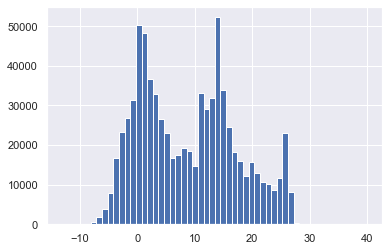

In [27]:
#petite visualization
nutridata['nutri-score_calculated'].hist(bins=int(nutridata['nutri-score_calculated'].max() - nutridata['nutri-score_calculated'].min() + 1));

In [28]:
# re divided dataframe to allow a simpler transformation of score into letter
nutridata_beverages = nutridata[nutridata['Category_Food']=='Beverages']
nutridata_not_beverages = nutridata[nutridata['Category_Food']!='Beverages']

In [29]:
# NUTRILETTER

#letter bins
letter_bins_aliments = [nutridata['nutri-score_calculated'].min() - 1, 0, 2.9, 10.9, 18.9, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages = [nutridata['nutri-score_calculated'].min() - 1, 2.5, 5.5, 9.5, nutridata['nutri-score_calculated'].max()]

#letter
nutridata_not_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_not_beverages['nutri-score_calculated'], letter_bins_aliments, labels=['a','b','c','d','e'])
nutridata_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages['nutri-score_calculated'], letter_bins_beverages, labels=['b','c','d','e'])


/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [30]:
nutriframes = [nutridata_not_beverages, nutridata_beverages]
nutridata = pd.concat(nutriframes)

In [31]:
nutridata['nutri-score_letter_CALCULATED'].value_counts()

d    247561
a    160302
c    156517
e    118151
b     87801
Name: nutri-score_letter_CALCULATED, dtype: int64